<a href="https://colab.research.google.com/github/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Portfolio
*by Fabian Leuk (csba6437/12215478)*

## Session 6: Hugging Face Pre-Trained Models

### Key Learnings



*   The time needed to fine-tune a transformers model is dependent on the data size and was 10 hours for a data set of 52000 abstracts with 3 epochs and a batch size of 8
*   huggingface transformers supports the creation and retrieval of checkpoints during the learning phase, which is especially important in case training is interrupted e.g., when training models on large data sets
*   Checkpoints are saved by default after 500 batches. As a checkpoint saves the whole model, it takes up to 2 GB of data. OutOfMemoryErrors can be the consequence. However, transformers Trainer has an option to delete old checkpoints.
*   The use of CUDA and GPUs can decrease training time dramatically because of the parallel computational power of GPUs (https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d)
*  ML librariers can be buggy sometimes, so that we had to use Transformers 4.28.0 instead of the latest version
*  Transformers expects dataset to have the columns "text" and "labels"
*  Creating a Confusion matrix with matplotlib
*  Creating a San Key diagram with matplotlib
*  Data Labeling is time-consuming
*  Data Rot affected the results of this learning portfolio heavily






### Application

I will apply the knowledge gained throughout this session to my personal financial transactional data. I am training NLP models from the huggingface transformers library using financial transaction data from 2022. Then, I proceed to create an expense overview with current transaction data of April 2023.




#### Data Preparation

I used the following code to label my financial transactions. As I found it quite inconvenient to do so in Google Colab, I did it on my local machine.

```
import os
import csv

directory = '/Users/fabian/Downloads/data/'
target_directory = '/Users/fabian/Downloads/labeled_data/'

expense_categories = {
    1: 'Groceries',
    2: 'Dining/Restaurants',
    3: 'Utilities',
    4: 'Transportation',
    5: 'Rent/Mortgage',
    6: 'Entertainment',
    7: 'Travel',
    8: 'Shopping',
    9: 'Health/Wellness',
    10: 'Education',
    11: 'Insurance',
    12: 'Investments',
    13: 'Miscellaneous',
    14: 'Hobbies',
    15: 'Home',
    16: 'Irrelevant'
}

def display_menu():
    print("Select a category:")
    items = list(expense_categories.items())

    # Calculate the maximum lengths of the second values
    max_value_length = max(len(pair[1]) for pair in items[1::2])

    # Iterate over the list and print key-value pairs
    for i in range(0, len(items), 2):
        pair1 = items[i]
        pair2 = items[i + 1] if i + 1 < len(items) else ('', '')  # Handle odd number of items

        print('{:<15}: {:<{value_width}}\t{:<15}: {:<{value_width}}'.format(pair1[0], pair1[1], pair2[0], pair2[1],
                                                                            value_width=max_value_length))


def get_category_choice():
    while True:
        try:
            choice = int(input("Enter the category number: "))
            if 0 <= choice <= 16:
                return choice
            else:
                print("Invalid category number. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")


for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='iso-8859-1', errors='replace') as csv_file:
            reader = csv.DictReader(csv_file, delimiter=";")
            fieldnames = reader.fieldnames[:-1] + ['Category']
            with open(os.path.join(target_directory + filename), 'a', newline='') as output_file:
              writer = csv.DictWriter(output_file, fieldnames=fieldnames, delimiter=';')
              writer.writeheader()
              for row in reader:
                print(row)
                display_menu()
                choice = get_category_choice()
                row['Category'] = expense_categories[choice]
                del row['']
                writer.writerow(row)
```



Next, I will load the labeled data into Colab and extract the relevant information for training.

In [131]:
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import data_table
from sklearn.model_selection import train_test_split

data_table.enable_dataframe_formatter()

drive.mount('/content/drive')

bank_account_data = '/content/drive/My Drive/SE_Digital_Organizations/transaction_data/Bank_Account_2022.csv'
credit_card_data = '/content/drive/My Drive/SE_Digital_Organizations/transaction_data/Credit_Card_2022.csv'

data = pd.DataFrame()


bank_account_data = pd.read_csv(bank_account_data, delimiter=';')
credit_card_data = pd.read_csv(credit_card_data, delimiter=';')

credit_card_data.head(10)

data['text'] = pd.concat([bank_account_data["Auftraggeber / Begünstigter"],credit_card_data["Beschreibung"]])
data['labels'] = pd.concat([bank_account_data["Category"],credit_card_data["Category"]])
data['betrag'] = pd.concat([bank_account_data["Betrag (EUR)"],credit_card_data["Betrag (EUR)"]])
data['datum'] = pd.concat([bank_account_data["Wertstellung"],credit_card_data["Wertstellung"]])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, I will be performing some data transformations. I will convert Betrag to a float, as well as datum to a date. Then, I will remove all data that does not have text information as well as all data that has been marked as "Irrelevant".

In [3]:
data['betrag'] = data['betrag'].str.replace('.', '').str.replace(',', '.').astype(float)
data['datum'] = pd.to_datetime(data['datum'])

<ipython-input-3-370278172a7b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['betrag'] = data['betrag'].str.replace('.', '').str.replace(',', '.').astype(float)
<ipython-input-3-370278172a7b>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['datum'] = pd.to_datetime(data['datum'])


In [4]:
data = data[data['text'].notna()]
data = data[data['labels'] != "Irrelevant"]

Our final step in data preparation is to split the data into training, validation and test data using a stratified sampling approach.

In [132]:
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['labels'], random_state=42)
train_data, validation_data = train_test_split(train_data, test_size=0.1, stratify=train_data['labels'], random_state=42)

print("Length of training, validation and test set")
print((len(train_data), len(validation_data), len(test_data)))

Length of training, validation and test set
(556, 62, 69)


#### Training

I will train a sequence classification model using huggingface Transformers. As a pretrained model I will use bert-base-uncased (https://huggingface.co/bert-base-uncased) and compare it to finbert-pretain(https://huggingface.co/FinanceInc/finbert-pretrain).

In [7]:
!pip uninstall transformers -y

In [8]:
!pip install transformers==4.28.0
!pip install accelerate
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3

In [43]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer
from datasets import Dataset,DatasetDict

# Make data comply to transformers standard: text and labels
train_data_transformers = train_data.loc[:, ['text', 'labels']]
test_data_transformers = test_data.loc[:, ['text', 'labels']]
valid_data_transformers = validation_data.loc[:, ['text', 'labels']]

# convert to datasets
train_ds = Dataset.from_pandas(train_data_transformers)
valid_ds = Dataset.from_pandas(valid_data_transformers)
test_ds = Dataset.from_pandas(test_data_transformers)

dataset_dict = DatasetDict({'train': train_ds, 'validation': valid_ds, 'test': test_ds})

id2label = {
    0: 'Home',
    1: 'Groceries',
    2: 'Dining/Restaurants',
    3: 'Utilities',
    4: 'Transportation',
    5: 'Rent/Mortgage',
    6: 'Entertainment',
    7: 'Travel',
    8: 'Shopping',
    9: 'Health/Wellness',
    10: 'Education',
    11: 'Insurance',
    12: 'Investments',
    13: 'Miscellaneous',
    14: 'Hobbies'
}
label2id = {value: key for key, value in id2label.items()}

##### Bert-Base-Uncased

While training this model I have used different batch sizes, epochs numbers and learning rates. The model achieves accuracies on the validation set of up to 80 %. Unfortunately, the results during training are inconsistent as the validation loss rises sometimes.

In [91]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(x):
    tokens = tokenizer(x['text'], truncation=True, padding=True)
    tokens["labels"] = [label2id[label] for label in x["labels"]]
    return tokens

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

In [83]:
from transformers import BertForSequenceClassification
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("/content/drive/My Drive/SE_Digital_Organizations/checkpoints/", evaluation_strategy="epoch", 
                                  per_device_train_batch_size=32, per_device_eval_batch_size=32,
                                  num_train_epochs = 20, learning_rate = 6e-05)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=15, id2label=id2label, label2id=label2id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at FinanceInc/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.752095,0.535714
2,No log,1.325956,0.625000
3,No log,1.098272,0.678571
4,No log,1.024755,0.732143
5,No log,0.974984,0.750000
6,No log,0.993675,0.732143
7,No log,0.981356,0.785714
8,No log,1.052028,0.732143
9,No log,0.974136,0.767857
10,No log,1.026717,0.767857


TrainOutput(global_step=192, training_loss=0.5096109708150228, metrics={'train_runtime': 26.0901, 'train_samples_per_second': 229.973, 'train_steps_per_second': 7.359, 'total_flos': 58590158868000.0, 'train_loss': 0.5096109708150228, 'epoch': 12.0})

##### Finbert-pretrain

While training this model I have used different batch sizes, epochs numbers and learning rates. The model achieves accuracies on the validation set of up to 80 % and appears to be a little more consistent. While the advantage over bert-base-uncased is marginal if at all, I will use this model going further into testing.

In [78]:
# model and tokenizer definition
checkpoint = "FinanceInc/finbert-pretrain"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# tokenize text and convert labels into label id
def tokenize_function(x):
    tokens = tokenizer(x['text'], truncation=True, padding=True)
    tokens["labels"] = [label2id[label] for label in x["labels"]]
    return tokens

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

In [84]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("/content/drive/My Drive/SE_Digital_Organizations/checkpoints/", evaluation_strategy="epoch", 
                                  per_device_train_batch_size=32, per_device_eval_batch_size=32,
                                  num_train_epochs = 20, learning_rate = 6e-05)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=15, id2label=id2label, label2id=label2id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at FinanceInc/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.658555,0.571429
2,No log,1.292318,0.660714
3,No log,1.052310,0.696429
4,No log,1.010989,0.732143
5,No log,1.028072,0.750000
6,No log,1.098821,0.750000
7,No log,0.963807,0.785714
8,No log,1.044515,0.750000
9,No log,0.998630,0.803571
10,No log,1.100446,0.750000


TrainOutput(global_step=320, training_loss=0.2724463939666748, metrics={'train_runtime': 49.4722, 'train_samples_per_second': 202.134, 'train_steps_per_second': 6.468, 'total_flos': 97650264780000.0, 'train_loss': 0.2724463939666748, 'epoch': 20.0})

#### Testing

The finbert-pretain fine-tuned model achieves an accuracy of 90.32 % on the test data set considering it's most probable result. I have used a confusion matrix and and a sankey diagram to visualize the test results.

In [85]:
preds = trainer.predict(tokenized_datasets["test"])
preds

PredictionOutput(predictions=array([[-3.25784743e-01,  8.72055531e+00, -4.14039850e-01,
        -3.92978370e-01, -3.00152212e-01, -6.50915980e-01,
        -4.92755830e-01, -5.21382272e-01,  2.32388023e-02,
        -5.00370920e-01, -3.26946467e-01, -1.03469026e+00,
        -6.32654846e-01, -8.80420446e-01, -5.08641064e-01],
       [-1.88453007e+00, -7.07617164e-01,  1.04368091e+00,
        -7.21173584e-01, -1.33192754e+00, -5.47856748e-01,
        -8.26871216e-01, -2.34317556e-01, -6.54906392e-01,
         5.92443673e-03, -4.61117625e-01, -9.14917529e-01,
        -1.13630557e+00, -5.49340844e-01,  7.14111853e+00],
       [-3.42479259e-01,  8.61395645e+00, -4.17393565e-01,
        -1.63997561e-01, -3.73109192e-01, -4.23802704e-01,
        -4.07829285e-01, -8.06006372e-01,  8.30279514e-02,
        -4.66312259e-01, -2.18518257e-01, -9.67363060e-01,
        -8.28049123e-01, -9.24489081e-01, -5.61148822e-01],
       [-2.09248737e-01, -9.13738191e-01, -5.77771008e-01,
         9.94500279e-01,

In [86]:
single_hits = 0
triple_hits = 0
wrong_single_hits_per_category = {}
wrong_triple_hits_per_category = {}

for i in range(len(preds.predictions)):
  if np.argmax(preds.predictions[i]) == tokenized_datasets["test"][i]["labels"]:
    single_hits += 1
  else:
    if wrong_single_hits_per_category.get(id2label[tokenized_datasets["test"][i]["labels"]]) is None:
        wrong_single_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] = 1
    else:
        wrong_single_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] += 1
  if tokenized_datasets["test"][i]["labels"] in np.argpartition(preds.predictions[i], -3)[-3:]:
    triple_hits += 1
  else:
    if wrong_triple_hits_per_category.get(id2label[tokenized_datasets["test"][i]["labels"]]) is None:
        wrong_triple_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] = 1
    else:
        wrong_triple_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] += 1

sorted_single_hit_fails = dict(sorted(wrong_single_hits_per_category .items(), key=lambda x: x[1], reverse=True))
sorted_triple_hit_fails = dict(sorted(wrong_triple_hits_per_category .items(), key=lambda x: x[1], reverse=True))

print("Single and Triple Hit Accuracy")
print((single_hits/len(preds.predictions), triple_hits/len(preds.predictions)))
print("Category to wrong prediction single")
print(sorted_single_hit_fails)
print("Category to wrong prediction triple")
print(sorted_triple_hit_fails)

Single and Triple Hit Accuracy
(0.9032258064516129, 0.9354838709677419)
Category to wrong prediction single
{'Transportation': 2, 'Dining/Restaurants': 1, 'Shopping': 1, 'Health/Wellness': 1, 'Hobbies': 1}
Category to wrong prediction triple
{'Dining/Restaurants': 1, 'Health/Wellness': 1, 'Hobbies': 1, 'Transportation': 1}


In [87]:

results = []
for arr in preds.predictions:
    max_index = np.argmax(arr)
    results.append(max_index)

print(results)

[1, 14, 1, 4, 7, 7, 11, 4, 14, 1, 1, 1, 3, 1, 12, 8, 8, 1, 2, 1, 2, 3, 4, 2, 4, 12, 14, 1, 1, 6, 0, 11, 4, 13, 1, 4, 5, 3, 2, 1, 0, 2, 1, 1, 1, 13, 13, 1, 1, 6, 14, 14, 4, 13, 2, 12, 4, 2, 2, 2, 11, 5]


In [88]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(tokenized_datasets["test"]["labels"], results)
class_names = list(label2id.keys())
class_names.remove("Health/Wellness")
cm

Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  5]]


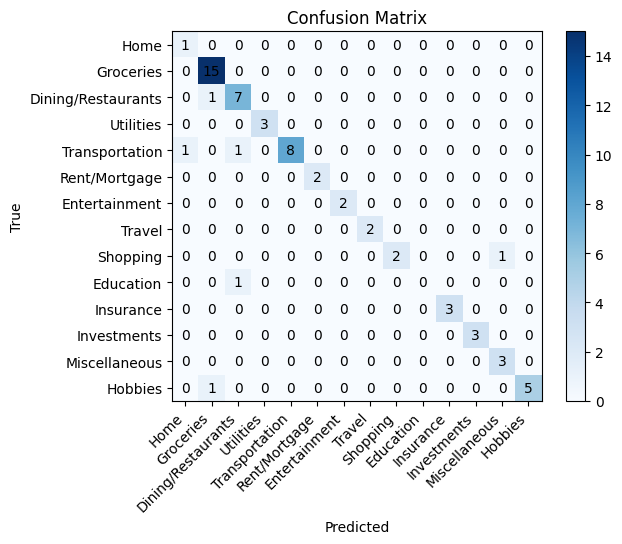

In [89]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

plt.show()

In [90]:
# https://github.com/ChawlaAvi/Daily-Dose-of-Data-Science/blob/main/Plotting/Confusion-Matrix-Sankey.ipynb

import pandas as pd
import numpy as np
from plotly import graph_objects as go

RED = "rgba(245,173,168,0.6)"
GREEN = "rgba(211,255,216,0.6)"

def plot_confusion_matrix_as_sankey(confusion_matrix,  class_labels = None):
    
    """
    plots sankey diagram from confusion matrix and class labels
    
    The function acceps:
        - confusion_matrix
                [[TP, FN]
                 [FP, TN]]
        - class_labels:
            class_labels[0]: Label for positive class
            class_labels[1]: Label for negative class
        
    """
    
    df, labels = create_df_from_confusion_matrix(confusion_matrix,  class_labels)
    
    fig = go.Figure(data=[go.Sankey(
    
    node = dict(
      pad = 100,
      thickness = 100,
      line = dict(color = "gray", width = 1.0),
      label = labels,
      color = GREEN,
      hovertemplate = "%{label} has total %{value:d} instances<extra></extra>"
    ),
    link = dict(
      source = df.actual, 
      target = df.predicted,
      value = df.instances,
      color = df.colour,
      customdata = df['link_text'], 
      hovertemplate = "%{customdata}<extra></extra>"  
    ))])

    fig.update_layout(title_text="Confusion Matrix Sankey Diagram", font_size=15,
                      width=1600, height=800)
    
    return fig

def create_df_from_confusion_matrix(confusion_matrix, class_labels=None):
    
    
    ## create a dataframe
    if not len(class_labels):
        ## if class labels not received, created dummy headers and index
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True Class-{i+1}" for i in range(confusion_matrix.shape[0])],
                          columns=[f"Predicted Class-{i+1}" for i in range(confusion_matrix.shape[0])])
    else:
        ## create headers and index using class labels
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True {i}" for i in class_labels],
                          columns=[f"Predicted {i}" for i in class_labels])
    
    ## unpivot dataframe and rename columns
    df = df.stack().reset_index()
    df.rename(columns={0:'instances', 'level_0':'actual', 'level_1':'predicted'}, inplace=True)
    """
    >>> df
            actual          predicted     instances
          True Fraud    Predicted Fraud       10
          True Fraud    Predicted Legit       4
          True Legit    Predicted Fraud       2
          True Legit    Predicted Legit       12
    
    """
    
    ## determine classification color based on correct classification or not.
    df["colour"] = df.apply(lambda x: 
                               GREEN if x.actual.split()[1:] == x.predicted.split()[1:] 
                               else RED, axis=1)

    node_labels = pd.concat([df.actual, df.predicted]).unique()
    node_labels_indices = {label:index for index, label in enumerate(node_labels)}
    
    ## map actual and predicted columns to numbers
    df =  df.assign(actual    = df.actual.apply(lambda x: node_labels_indices[x]),
                    predicted = df.predicted.apply(lambda x: node_labels_indices[x]))
    
    ## determine text for hovering on connecting edges of sankey diagram
    def get_link_text(row):
        if row["colour"] == GREEN:
            instance_count = row["instances"]
            source_class = ' '.join(node_labels[row['actual']].split()[1:])
            target_class = ' '.join(node_labels[row['predicted']].split()[1:])
            return f"{instance_count} {source_class} instances correctly classified as {target_class}"
        else:
            instance_count = row["instances"]
            source_class = ' '.join(node_labels[row['actual']].split()[1:])
            target_class = ' '.join(node_labels[row['predicted']].split()[1:])
            return f"{instance_count} {source_class} instances incorrectly classified as {target_class}"
        
    df["link_text"] = df.apply(get_link_text, axis = 1)
    return df, node_labels


plot_confusion_matrix_as_sankey(cm,  class_names)

#### Going-Live

After testing, I put the model to use creating predictions for the month of April 2023 and continued to visualize my spendings using a pie diagram.

The results have been very poor. I think the main issue here is data rot: I have trained the model on a data set of 2022, where I lived and worked most of the time in Frankfurt. The recipients of my financial transactions however changed dramatically, as I moved to Innsbruck. For example I shop at Hofer here, whereas in Germany the data contained only "Aldi".

To address this issue, the model would need to be fine-tuned on fresher data.

In [133]:
bank_account_data = '/content/drive/My Drive/SE_Digital_Organizations/transaction_data/Bank_Account_04_2023.csv'
credit_card_data = '/content/drive/My Drive/SE_Digital_Organizations/transaction_data/Credit_Card_04_2023.csv'

data = pd.DataFrame()


bank_account_data = pd.read_csv(bank_account_data, encoding='iso-8859-1', delimiter=';')
credit_card_data = pd.read_csv(credit_card_data, encoding='iso-8859-1', delimiter=';')

credit_card_data.head(10)

data['text'] = pd.concat([bank_account_data["Auftraggeber / Begünstigter"],credit_card_data["Beschreibung"]])
data['betrag'] = pd.concat([bank_account_data["Betrag (EUR)"],credit_card_data["Betrag (EUR)"]])
data['datum'] = pd.concat([bank_account_data["Wertstellung"],credit_card_data["Wertstellung"]])

data['betrag'] = data['betrag'].str.replace('.', '').str.replace(',', '.').astype(float)
data['datum'] = pd.to_datetime(data['datum'])
data['labels'] = 0 

<ipython-input-133-bc2ca49b0204>:16: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-133-bc2ca49b0204>:17: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [134]:
dataset = Dataset.from_pandas(data.loc[:, ['text', 'labels']])

In [135]:
def tokenize_function(x):
    tokens = tokenizer(x['text'], truncation=True, padding=True)
    return tokens

tokenized_dataset = dataset.map(tokenize_function, batched=True)

preds = trainer.predict(tokenized_dataset)

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

In [136]:
results = []

for arr in preds.predictions:
    max_index = np.argmax(arr)
    results.append(max_index)

print(results)

[1, 4, 13, 2, 7, 7, 2, 13, 14, 2, 9, 2, 1, 4, 1, 14, 13, 14, 14, 1, 14, 8, 13, 14, 14, 1, 1, 1, 4, 2, 1, 2, 14, 2, 14, 2, 1, 1, 14, 2, 13, 2, 14, 14, 14, 14, 2, 1, 14, 1, 14, 14, 1, 1, 1, 1, 1, 4, 1, 1, 14, 7, 2, 2, 4, 1, 14, 14]


In [137]:
data['Category'] = [id2label[res] for res in results]

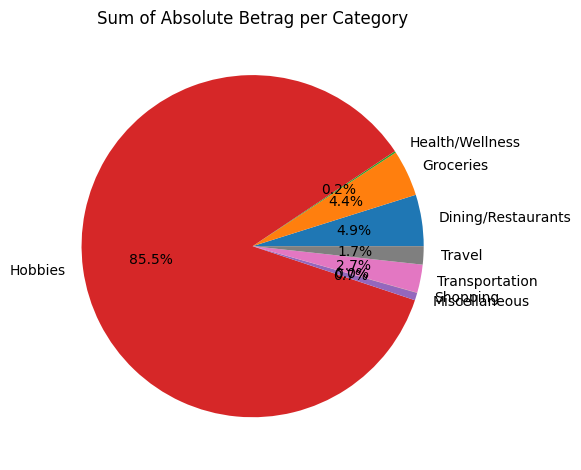

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = data.groupby('Category')['betrag'].sum().abs()

plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%')

plt.title('Sum of Expenses per Category')

plt.tight_layout()
plt.xticks(rotation='vertical')
plt.show()